<a href="https://colab.research.google.com/github/claredavies/DataScienceCoursework/blob/master/DataScience3Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import tweepy as tw
import pandas as pd
import sys 
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
from tweepy import Stream
import time
import datetime

# Authenticate to Twitter
auth = tw.OAuthHandler("iy5oGHP6q1b6Zg14XpVnGct9z", 
    "Y3iHHViLz7XVWw0sSjiHaRWGZVeSnSmjugmtT8BwJw0R0ZK9X7")
auth.set_access_token("1450047668554698752-ogdyTTSKpSEwBMOVR2Teuu7uohrp6z", 
    "trIEAFunzkj70ILmhaJ8jFgoIOQvF1rIy9zDUJb325TGm")

api = tw.API(auth)

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [3]:
# The search term you want to find
query = "#anxiety -filter:retweets"

until_date = datetime.datetime.now().date()
d = datetime.timedelta(days = 7)
since_date = until_date - d

# usually fetches 5757
print("Gathering data across a week between  " + since_date + "  to  " + until_date)

tweets = tw.Cursor(api.search,q=query,count = 100,lang="en",since=since_date, until=until_date, tweet_mode='extended').items()

# store the API responses in a list
tweets_copy = []

for tweet in tweets:
    tweets_copy.append(tweet)
    
print("Total Tweets fetched:", len(tweets_copy))

2021-10-21
2021-10-14
Total Tweets fetched: 5774


In [24]:
# intialize the dataframe
tweets_df = pd.DataFrame()

# populate the dataframe
for tweet in tweets_copy:
    hashtags = []
    try:
        for hashtag in tweet.entities["hashtags"]:
            hashtags.append(hashtag["text"])
            # for text need to call api again with tweet id
        text = api.get_status(id=tweet.id, tweet_mode='extended').full_text
    except:
        pass
    tweets_df = tweets_df.append(pd.DataFrame({ 
                                               'user_location': tweet.user.location,
                                               'user_description': tweet.user.description,
                                               'day': calendar.day_name[tweet.created_at.weekday()],
                                               'hour': tweet.created_at.hour,
                                               'text': text, 
                                               'hashtags': [' '.join(hashtags) if hashtags else None]
                                               }))
    tweets_df = tweets_df.reset_index(drop=True)

# show the dataframe
tweets_df.head(3)

,user_location,user_description,day,hour,text,hashtags
0,,astrologer. vocalist. songwriter. dog mom. her...,Wednesday,23,The mind cannot hold conflicting beliefs and f...,ASTRO #astrology #hsp #anxiety #depression #SE...
1,"Boulder CO, USA",Peter Strong - Psychotherapist specializing in...,Wednesday,23,The mind cannot hold conflicting beliefs and f...,anxiety #anxietytreatment #anxietytherapy #anx...
2,"Kelowna, BC, Canada",Creating transformation and a taste for better...,Wednesday,23,The mind cannot hold conflicting beliefs and f...,shawnkcarpenter #artist #writer #coach #trauma...


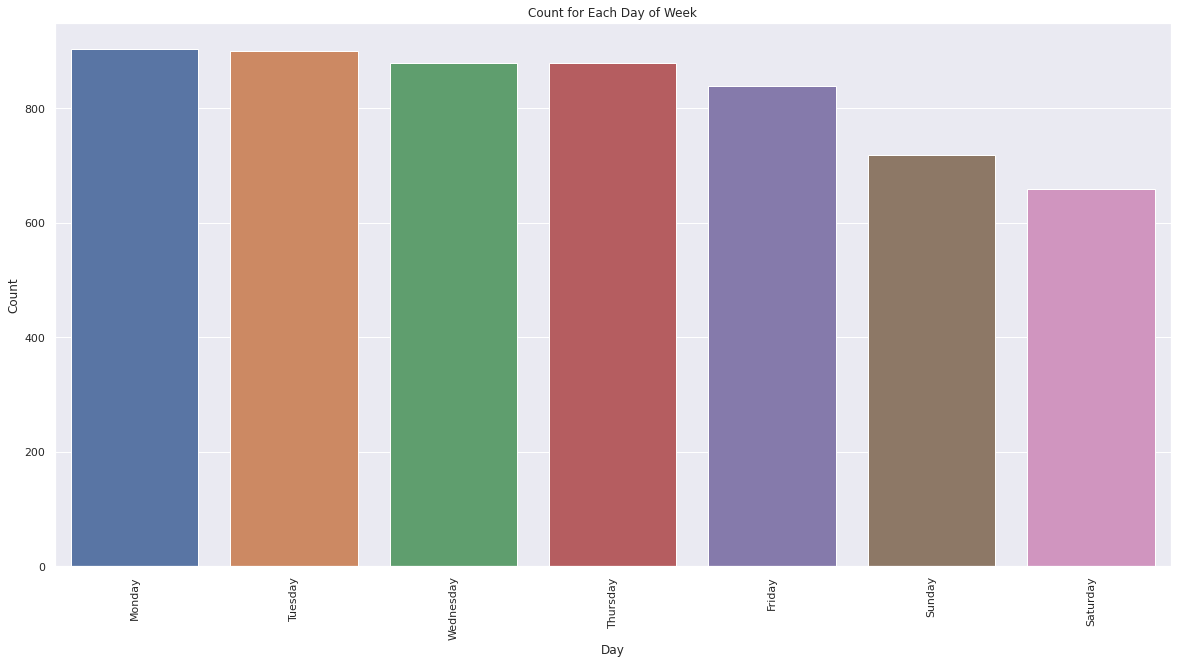

<Figure size 432x288 with 0 Axes>

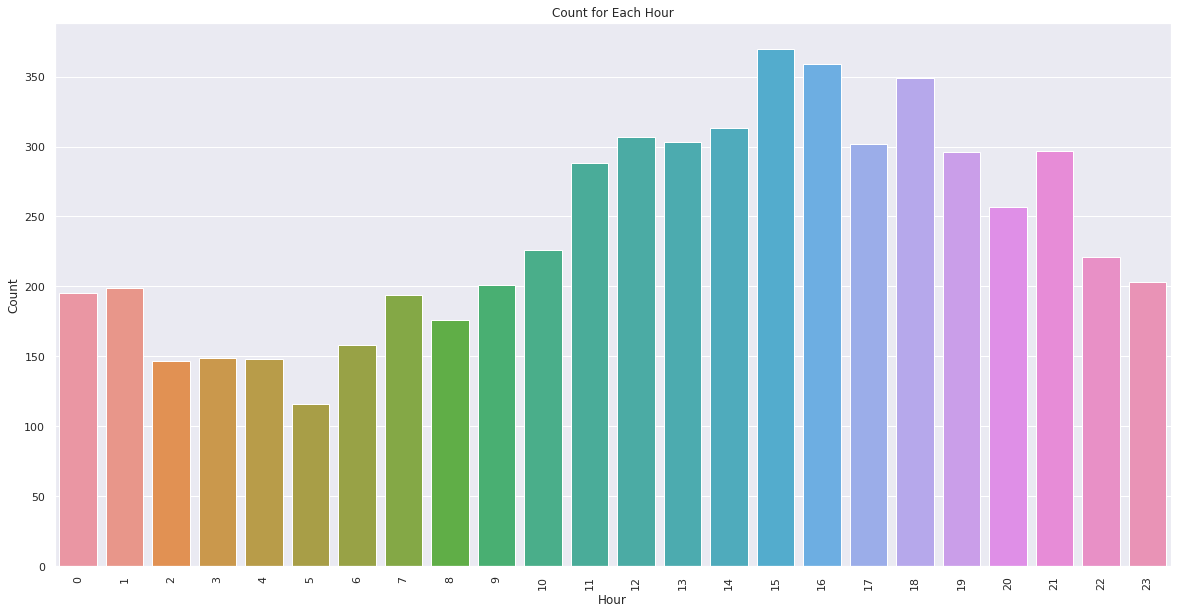

<Figure size 432x288 with 0 Axes>

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, ax1 = plt.subplots()
sns.barplot(x=tweets_df['day'].value_counts(sort=True).index, y=tweets_df['day'].value_counts(sort=True),ax=ax1).set_title("Count for Each Day of Week")
fig_text = plt.gcf()
fig_text.set_size_inches(20, 10)
plt.xticks(rotation=90)
plt.xlabel("Day")
plt.ylabel("Count")
plt.show()
plt.clf()

fig, ax2 = plt.subplots()
sns.barplot(x=tweets_df['hour'].value_counts(sort=True).index, y=tweets_df['hour'].value_counts(sort=True),ax=ax2).set_title("Count for Each Hour")
fig_text = plt.gcf()
fig_text.set_size_inches(20, 10)
plt.xticks(rotation=90)
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()
plt.clf()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128071 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128071 missing from current font.
  font.set_text(s, 0, flags=flags)


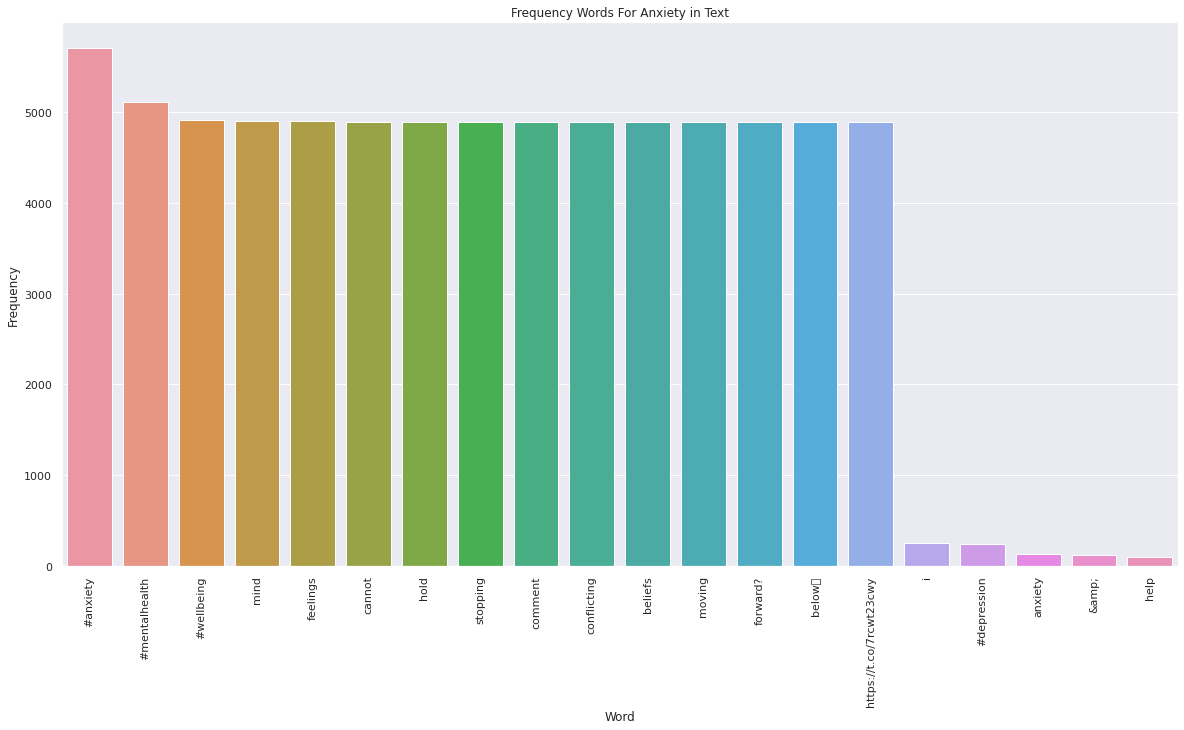

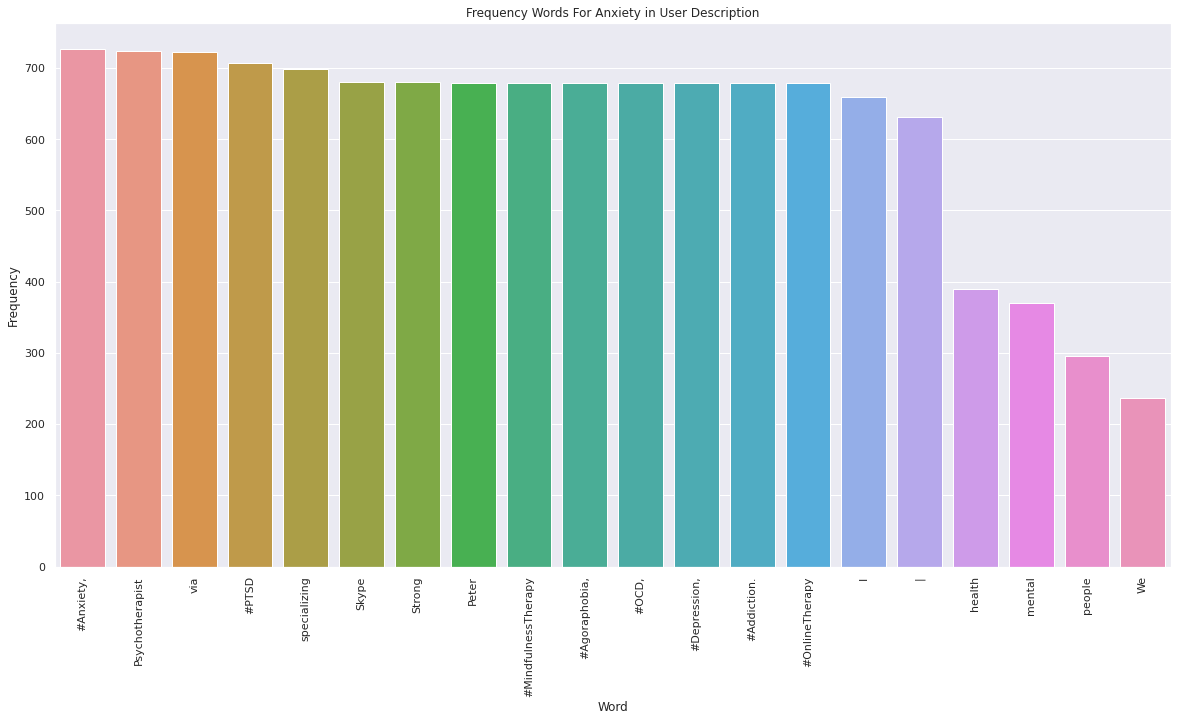

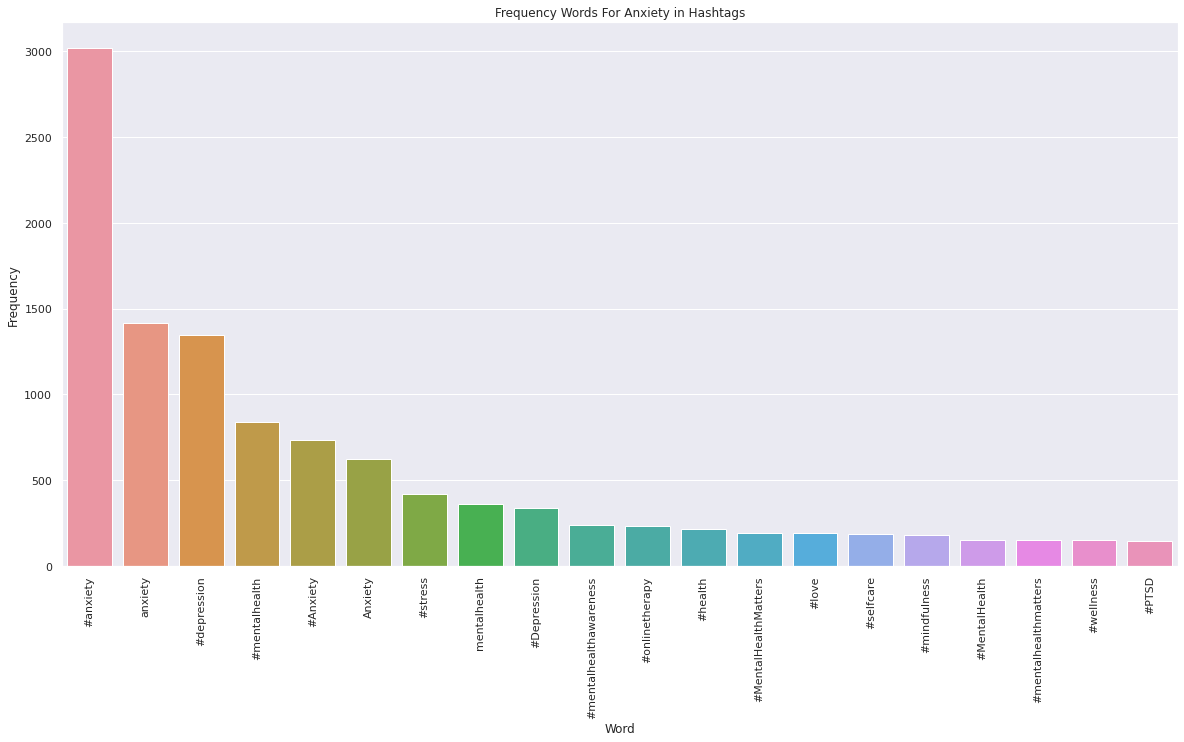

In [54]:
from collections import Counter
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
new_stop_words = ['-','The','What','_','&']
stop_words.extend(new_stop_words)

tweets_df['text'] = tweets_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
most_common_words_text = Counter(" ".join(tweets_df['text'].str.lower()).split()).most_common(20)
df_words_text = pd.DataFrame.from_records(most_common_words_text, columns=['Word','Frequency'])

fig, ax = plt.subplots()
sns.barplot(x='Word',y='Frequency',data=df_words_text,ax=ax).set_title("Frequency Words For Anxiety in Text")
fig_text = plt.gcf()
fig_text.set_size_inches(20, 10)
plt.xticks(rotation=90)

tweets_df['user_description'] = tweets_df['user_description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
most_common_words_user_description = Counter(" ".join(tweets_df['user_description']).split()).most_common(20)
df_words_user_description = pd.DataFrame.from_records(most_common_words_user_description, columns=['Word','Frequency'])

fig, ax2 = plt.subplots()
sns.barplot(x='Word',y='Frequency',data=df_words_user_description,ax=ax2).set_title("Frequency Words For Anxiety in User Description")
fig_user_description = plt.gcf()
fig_user_description.set_size_inches(20, 10)
plt.xticks(rotation=90)

tweets_df['hashtags'] = tweets_df['hashtags'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
most_common_words_hashtags = Counter(" ".join(tweets_df['hashtags']).split()).most_common(20)
df_words_hashtags = pd.DataFrame.from_records(most_common_words_hashtags, columns=['Word','Frequency'])

fig, ax2 = plt.subplots()
sns.barplot(x='Word',y='Frequency',data=df_words_hashtags,ax=ax2).set_title("Frequency Words For Anxiety in Hashtags")
fig_user_description = plt.gcf()
fig_user_description.set_size_inches(20, 10)
plt.xticks(rotation=90)